In [1]:
import matplotlib.pyplot as plt
import numpy as np
from flow_policy.toy.stochastic_flow_policy import StochasticFlowPolicy
from flow_policy.toy.plot_stochastic import (
    plot_probability_density_q,
    plot_probability_density_z,
    plot_probability_density_with_trajectories_q,
    plot_probability_density_with_trajectories_z,
)

from pydrake.all import (
    CompositeTrajectory,
    PiecewisePolynomial,
    Trajectory,
)

# Set seed
np.random.seed(0)

## Set sigma parameters

In [2]:
σ0 = 0.001
σ1 = 0.05

In [3]:
def demonstration_traj_right() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = PiecewisePolynomial.FirstOrderHold(
        breaks=[0, 0.25],
        samples=[[0, 0]],
    )
    piece_2 = PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, 0.62, 0.70, 0.5]],
        sample_dot_at_start=[[0.0]],
        sample_dot_at_end=[[-0.7]],
    )
    return CompositeTrajectory([piece_1, piece_2])

def demonstration_traj_left() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = PiecewisePolynomial.FirstOrderHold(
        breaks=[0, 0.25],
        samples=[[0, 0]],
    )
    piece_2 = PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, -0.62, -0.70, -0.5]],
        sample_dot_at_start=[[0.0]],
        sample_dot_at_end=[[0.7]],
    )
    return CompositeTrajectory([piece_1, piece_2])

traj_right = demonstration_traj_right()
traj_left = demonstration_traj_left()

## Plot demonstration trajectories

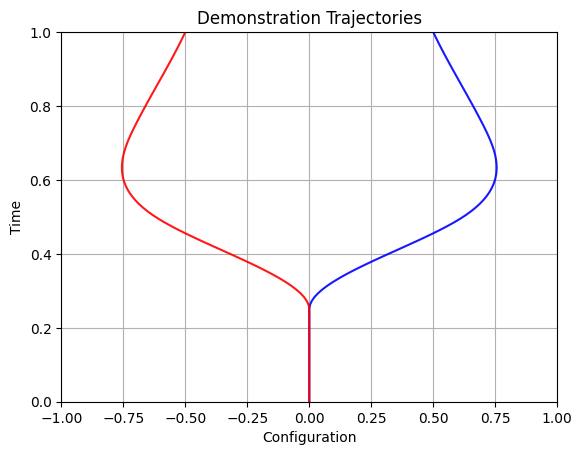

In [4]:
"""
Plot demonstration trajectory on x-y plane where x axis is the state in [-1, 1]
and y axis is the time in [0, 1].
"""
times = np.linspace(0, 1, 100)
plt.plot(traj_right.vector_values(times)[0], times, color='blue', alpha=0.9)
plt.plot(traj_left.vector_values(times)[0], times, color='red', alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('Configuration')
plt.ylabel('Time')
plt.title('Demonstration Trajectories')
plt.grid(True)
plt.show()

## Notation
| Symbol | Space | Meaning |
|:--------:|:-------:|:---------:|
| $t$ | $[0, 1]$ | Time |
| $q$ | $\mathbb{C}$| Configuration |
| $z$ | $\mathbb{C}$| Latent variable |
| $x = (q, z)$ | $\mathbb{C}^2$ | State |
| $v$ | $\mathbb{C}^2$ | Velocity |
| $o$ |  | Observation history |
| $v_\theta(q, z, t \mid o)$ | $\mathbb{R}^n$ | Learned flow policy |
| $\xi \sim \mathcal{D}$ | $[0, 1] \rightarrow \mathbb{C}$ | Random variable for demonstration trajectories |
| $\xi(t)$ | $\mathbb{C}$ | Configuration in the demonstration at time $t$ |
| $\dot{\xi}(t)$ | $\mathbb{C}$ | Velocity in the demonstration at time $t$ |


In this notebook, $x \equiv q$.

## Conditional flow

In [5]:
fp = StochasticFlowPolicy(trajectories=[traj_right], prior=[1.0], σ0=σ0, σ1=σ1)

Given $\xi \sim \mathcal{D}$ with associated observation history $o$, we extend the state space using a latent variable $z \in \mathbb{C}$. We define the initial distribution at $t = 0$ as follows.

<p style="text-align:center;"><ins>Initial sample</ins></p>

\begin{align*}
z_0 &\sim \mathcal{N}(0, I) \\
q_0 &\sim \mathcal{N}(\xi(0), \sigma_0^2)
\end{align*}

We use two hyperparameters $\sigma_0$ and $\sigma_1$ to represent how peaked the distribution should be at $t = 0$ and $t = 1$ respectively, where $\sigma_1 \geq \sigma_0$. For convenience, define the "residual standard deviation" $\sigma_r = \sqrt{\sigma_1^2 - \sigma_0^2}$. For an initial sample $(q_0, z_0)$, we define the *flow* trajectory as:

<p style="text-align:center;"><ins>Flow trajectory</ins></p>

\begin{align*}
q(t \mid \xi, x_0, z_0) &= q_0 + (\xi(t) - \xi(0)) + (\sigma_r t)z_0 \tag{1} \\
z(t \mid \xi, x_0, z_0) &= (1 - (1 - \sigma_1)t)z_0 + t \xi(t) \tag{2}
\end{align*}

The flow is a diffeomorphism from $\mathbb{C}^2$ to $\mathbb{C}^2$ for every $t \in [0, 1]$. At time $t$, the flow of the trajectory starting from $(q_0, z_0)$ is:

\begin{align*}
\dot{q}(t \mid \xi, x_0, z_0) &= \dot{\xi}(t) + \sigma_r z_0 \tag{3} \\
\dot{z}(t \mid \xi, x_0, z_0) &= \xi(t) + t \dot{\xi}(t) - (1 - \sigma_1)z_0 \tag{4}
\end{align*}

The flow induces a velocity field at every $(q, z, t)$. The conditional velocity field $v_\theta(q, z, t \mid o)$ by first inverting the flow transformation in Eq (1, 2), and plugging that into Eq. (3, 4):

- First, given $q = q(t \mid \xi, x_0, z_0)$ and $z = z(t \mid \xi, x_0, z_0)$, invert the flow to compute $q_0$ and $z_0$.
\begin{align*}
z_0 &= \frac{z - t \xi(t)}{1 - (1 - \sigma_1)t} \\
q_0 &= q - (\xi(t) - \xi(0)) - (\sigma_r t) z_0
\end{align*}
- Then, plug this into Eq. (3, 4) to compute the conditional velocity field:

<p style="text-align:center;"><ins>Conditional velocity field</ins></p>

\begin{align*}
v_q(q, z, t \mid \xi) &= \dot{\xi}(t) + \frac{\sigma_r(z - t \xi(t))}{1 - (1 - \sigma_1)t} \\
v_z(q, z, t \mid \xi) &= \xi(t) + t \dot{\xi}(t) - \frac{1 - \sigma_1}{1 - (1 - \sigma_1)t} \left(z - t \xi(t)\right)
\end{align*}

## Plot conditional probability path of right trajectory

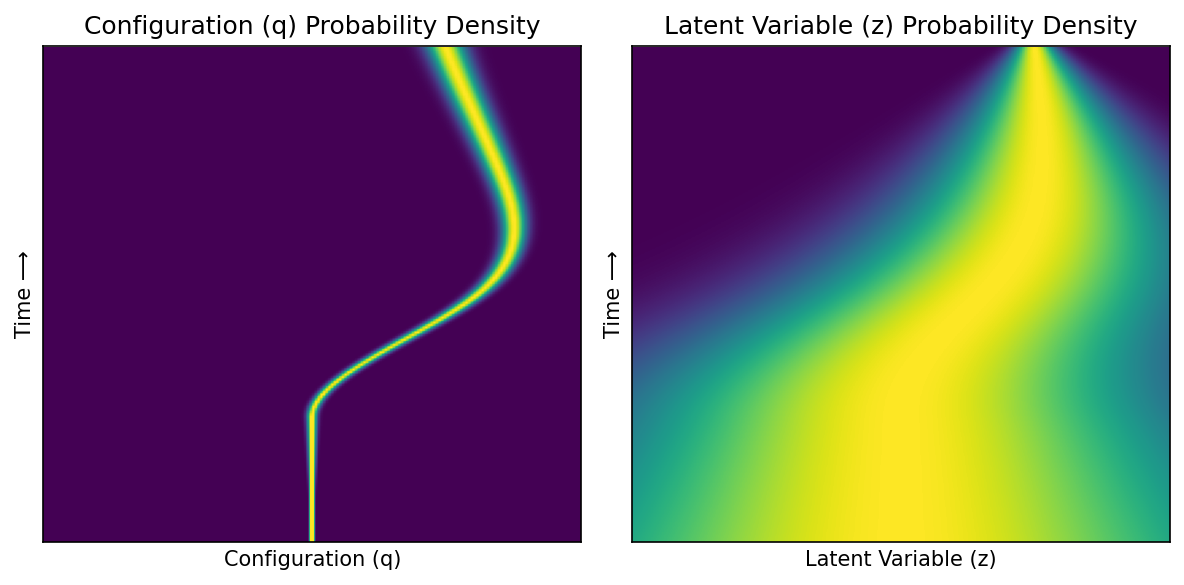

In [6]:
fig = plt.figure(figsize=(8, 4), dpi=150)

xs = np.linspace(-1, 1, 200)
ts = np.linspace(0, 1, 200)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_q(fp, ts, xs, ax1)
plot_probability_density_z(fp, ts, xs, ax2)

ax1.set_title('Configuration (q) Probability Density', size='large')
ax2.set_title('Latent Variable (z) Probability Density', size='large')

ax1.set_xlabel('Configuration (q)')
ax1.set_ylabel('Time ⟶')
ax2.set_xlabel('Latent Variable (z)')
ax2.set_ylabel('Time ⟶')

plt.tight_layout()
plt.show()

## Plot trajectories under conditional flow of right trajectory

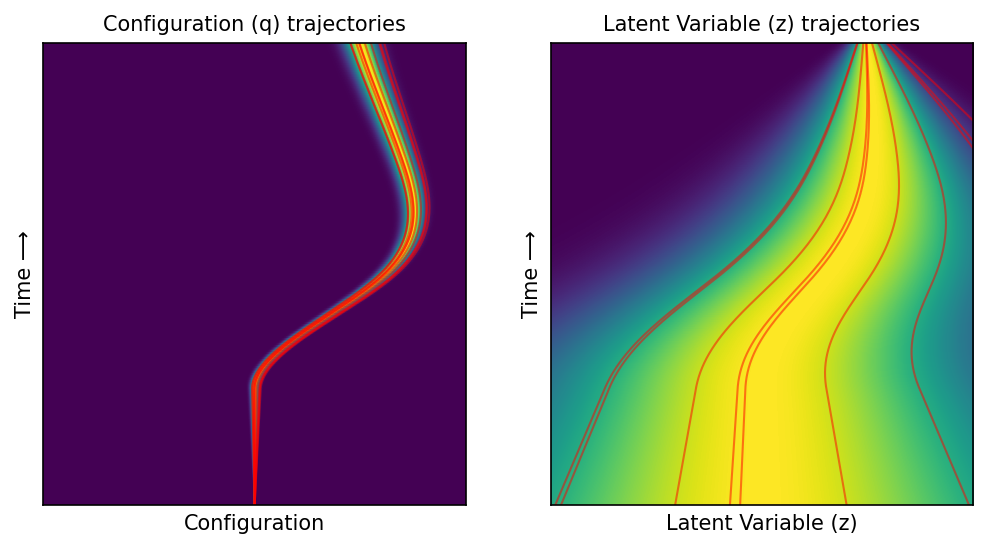

In [7]:
q_starts = [0.0] * 10
z_starts_pos = np.abs(np.random.randn(5))
z_starts_neg = -np.abs(np.random.randn(5))
z_starts = sorted(np.concatenate([z_starts_neg, z_starts_pos]))
colors = ['red'] * 5 + ['red'] * 5

fig = plt.figure(figsize=(8, 4), dpi=150)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_with_trajectories_q(
    fp, ax1, q_starts, z_starts, colors, num_points_x=400,)
plot_probability_density_with_trajectories_z(
    fp, ax2, q_starts, z_starts, colors, num_points_x=400,)
plt.show()


# Marginal flow

In [8]:
fp = StochasticFlowPolicy(trajectories=[traj_right, traj_left], prior=[0.5, 0.5], σ0=σ0, σ1=σ1)

## Training

Flow matching loss:
$$\mathcal{L}_\mathrm{FM}(\theta, \mathcal{D}) = \mathbb{E}_{\xi \sim \mathcal{D},\ t,\ x \sim x(t \mid \xi)} \big\| v_\theta(q, z, t \mid o) - v(q, z, t \mid \xi) \big\|_2^2$$

1. Sample trajectory from dataset $\xi \sim \mathcal{D}$.
2. Sample $q_0 \sim \mathcal{N}(\xi(0), \sigma_0^2)$.
3. Sample $z_0 \sim \mathcal{N}(0, I)$.
4. Sample $t \sim \text{Uniform}([0, 1])$.
5. Compute $q \sim q(t \mid \xi, x_0, z_0)$ and $z \sim z(t \mid \xi, x_0, z_0)$ using Eq. (1, 2).
6. Compute conditional velocity field $v_\theta(q, z, t \mid o)$ using Eq. (3, 4).
6. Compute L2 loss: $\| v_\theta(q, z, t \mid o) - v(q, z, t \mid \xi) \|_2^2$.


### Flow matching theorem

If $v^*(x, t \mid o)$ is the optimal velocity field that minimizes the flow matching loss, then the marginal distributions $p^*(x \mid t, o)$ induced by $v^*$ at *every* time $t$ is the "average" of the conditional flow distributions $p(x \mid t, \xi)$ over the training distribution.

$$p^*(x \mid t, o) = \mathbb{E}_{\xi} \left[ p(x \mid t, \xi) \right], \ \forall x \in \mathbb{C}^2, \forall t \in [0, 1]$$

where here, $x = (q, z)$.

## Plot marginal probability path

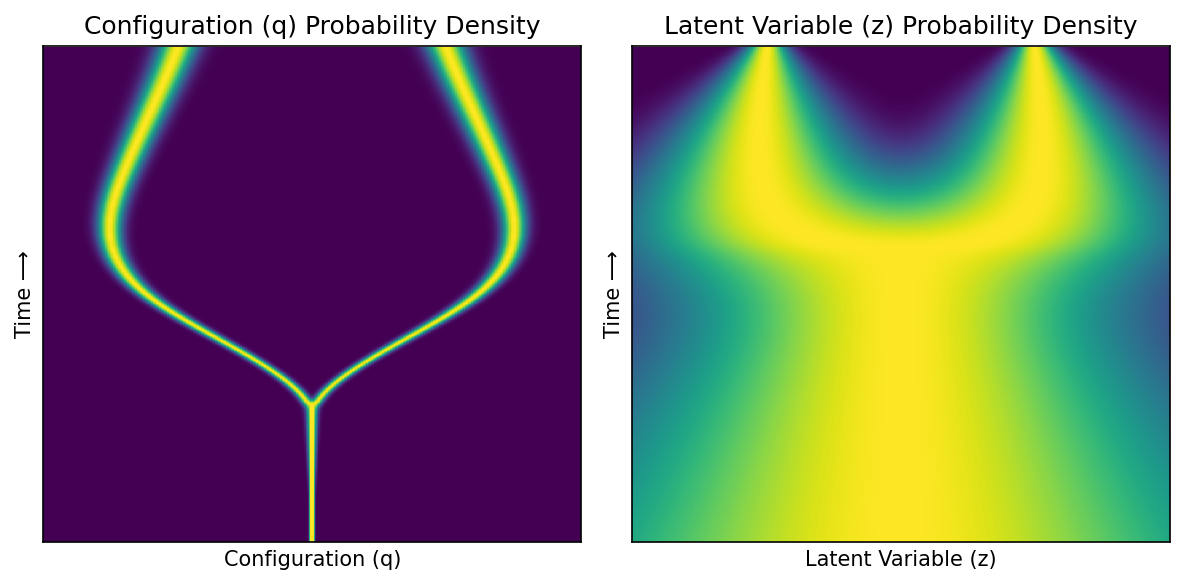

In [9]:
fig = plt.figure(figsize=(8, 4), dpi=150)

xs = np.linspace(-1, 1, 200)
ts = np.linspace(0, 1, 400)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_q(fp, ts, xs, ax1)
plot_probability_density_z(fp, ts, xs, ax2)

ax1.set_title('Configuration (q) Probability Density', size='large')
ax2.set_title('Latent Variable (z) Probability Density', size='large')

ax1.set_xlabel('Configuration (q)')
ax1.set_ylabel('Time ⟶')
ax2.set_xlabel('Latent Variable (z)')
ax2.set_ylabel('Time ⟶')

plt.tight_layout()
plt.show()

## Plot trajectories under marginal flow

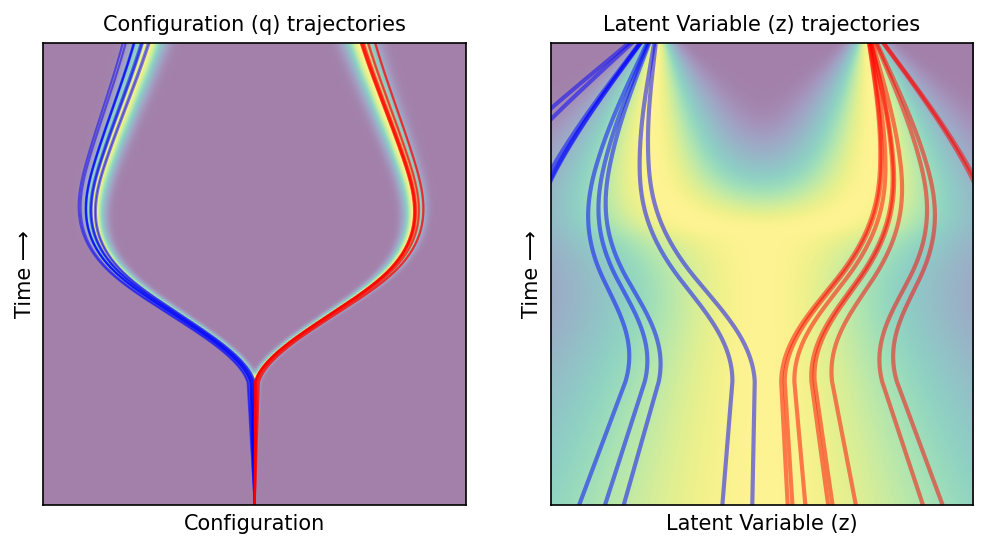

In [10]:
q_starts = [0.0] * 20
z_starts_pos = np.abs(np.random.randn(10))
z_starts_neg = -np.abs(np.random.randn(10))
z_starts = sorted(np.concatenate([z_starts_pos, z_starts_neg]))
colors = ['blue'] * 10 + ['red'] * 10

fig = plt.figure(figsize=(8, 4), dpi=150)

gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

plot_probability_density_with_trajectories_q(
    fp, ax1, q_starts, z_starts, colors, heatmap_alpha=0.5, linewidth=1, num_points_x=400,
)
plot_probability_density_with_trajectories_z(
    fp, ax2, q_starts, z_starts, colors, heatmap_alpha=0.5, linewidth=2, num_points_x=400,
)
plt.show()